In [460]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
from geopy.distance import vincenty
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate


In [461]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [462]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [463]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [464]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [465]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [466]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [467]:
len(listOfBs)

259

# 1. Data exploration

In [468]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message
print(f"Numbers of stations having received at least one message: {len(listOfBs)}")

Numbers of stations having received at least one message: 259


## 1.1. Overview train & test

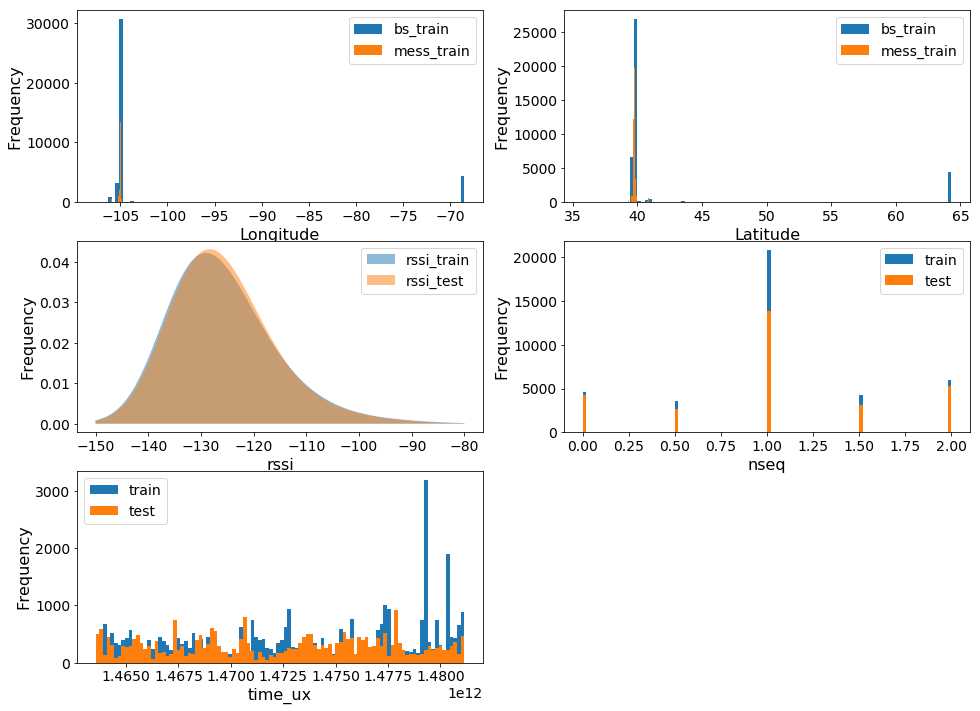

In [469]:
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
plt.hist(df_mess_train['bs_lng'], bins= 100, label='bs_train')
plt.hist(df['lng'], bins= 100, label='mess_train')
plt.ylabel("Frequency")
plt.xlabel("Longitude")
plt.legend()

plt.subplot(3,2,2)
plt.hist(df_mess_train['bs_lat'], bins= 100, label='bs_train')
plt.hist(df['lat'], bins= 100, label='mess_train')
plt.ylabel("Frequency")
plt.xlabel("Latitude")
plt.legend()

plt.subplot(3,2,3)
x_grid = np.linspace(-150, -80, 1000)
kde_rssi = KDEUnivariate(df_mess_train['rssi'])
kde_rssi.fit(bw=5, kernel='gau')
pdf_rssi = kde_rssi.evaluate(x_grid)
kde_rssi_test = KDEUnivariate(df_mess_test['rssi'])
kde_rssi_test.fit(bw=5, kernel='gau')
pdf_rssi_test = kde_rssi_test.evaluate(x_grid)
plt.fill_between(x_grid, pdf_rssi, alpha=0.5, label='rssi_train')
plt.ylabel("Frequency")
plt.xlabel("rssi")
plt.fill_between(x_grid, pdf_rssi_test, alpha=0.5, label='rssi_test')
plt.ylabel("Frequency")
plt.xlabel("rssi")
plt.legend()

plt.subplot(3,2,4)
plt.hist(df_mess_train['nseq'], bins= 100, label='train')
plt.hist(df_mess_test['nseq'], bins= 100, label='test')
plt.ylabel("Frequency")
plt.xlabel("nseq")
plt.legend()

plt.subplot(3,2,5)
plt.hist(df_mess_train['time_ux'], bins= 100, label='train')
plt.hist(df_mess_test['time_ux'], bins= 100, label='test')
plt.ylabel("Frequency")
plt.xlabel("time_ux")
plt.legend()




## 1.2. Spatial distribution of messages and base stations on training set

In [470]:
# Distance computation
df = df_mess_train.join(pos_train)

col = ['messid', 'bsid', 'bs_lat', 'bs_lng','lat', 'lng', 'rssi']
mess_lat = df['lat'] * np.pi / 180
bs_lat = df['bs_lat'] * np.pi / 180
mess_lng = df['lng'] * np.pi / 180
bs_lng = df['bs_lng'] * np.pi / 180

dlon = bs_lng - mess_lng
dlat = bs_lat - mess_lat
R = 6373
a = (np.sin(dlat/2))**2 + np.cos(mess_lat) * np.cos(bs_lat) * (np.sin(dlon/2))**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
distance = R * c
df['distance'] = distance


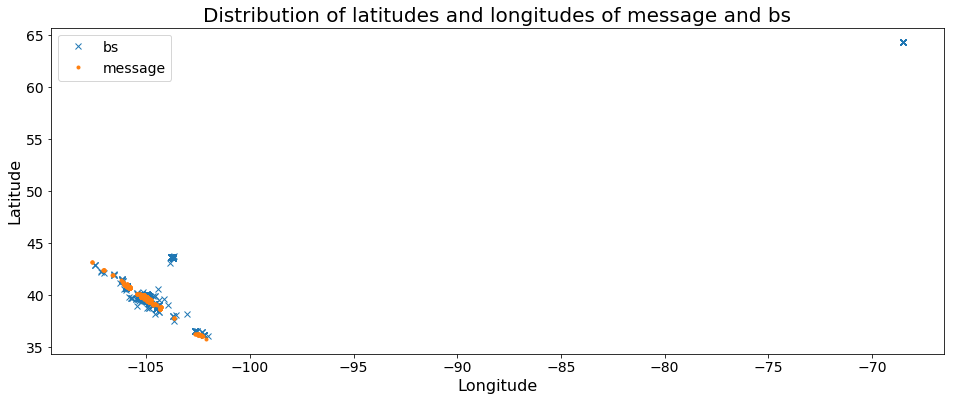

In [502]:

plt.figure(figsize=(16,6))
plt.plot(df['bs_lng'], df['bs_lat'], 'x', label='bs')
plt.xlabel('bs longitude' )
plt.ylabel('bs latitude')

plt.plot(df['lng'], df['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.title('Distribution of latitudes and longitudes of message and bs')
plt.legend()
#plt.xlim(-115,-100)

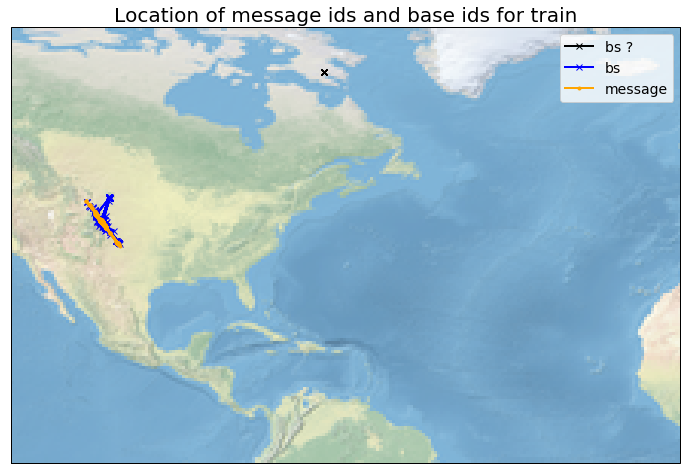

In [501]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-120, -10, 0, 60])
#ax.set_extent([-110, -90, 0, 60])


df_cp = df.copy()
df_cp = df_cp[df_cp['distance'] < 3000]
df_far = df.copy()
df_far = df_far[df_far['distance'] > 3000]

plt.title('Location of message ids and base ids for train')
plt.plot(df_far['bs_lng'], df_far['bs_lat'],
         color='k', linewidth=2, marker='x', label='bs ?',
         transform=ccrs.Geodetic(),
         )
plt.plot(df_cp['bs_lng'], df_cp['bs_lat'],
         color='blue', linewidth=2, marker='x', label='bs',
         transform=ccrs.Geodetic(),
         )
plt.plot(df_cp['lng'], df_cp['lat'],
         color='orange', linewidth=2, marker='.', label='message',
         transform=ccrs.Geodetic(),
         )
plt.legend()
plt.show()

Sigfox base stations distributions in USA


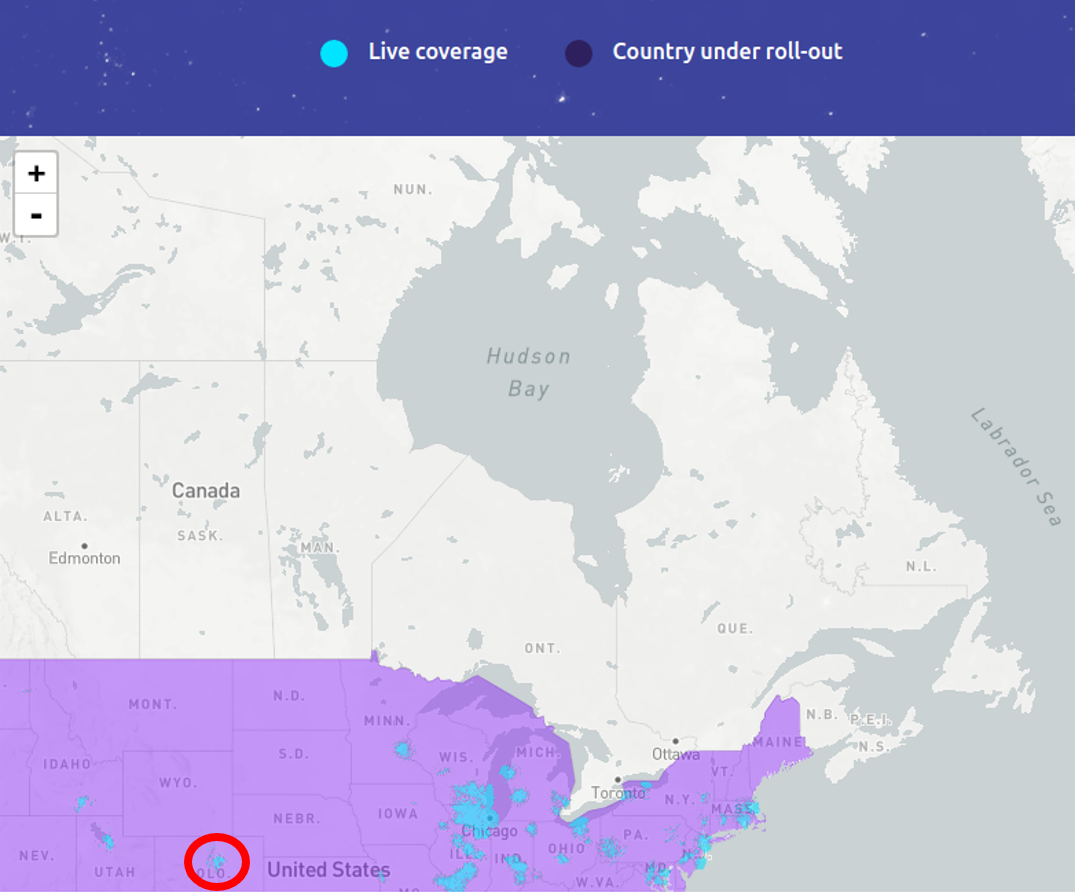

In [473]:
print('Sigfox base stations distributions in USA')
from IPython.display import Image
Image(filename='/home/alba/Downloads/sigfox_USA.png')

## Distances between messages and base stations

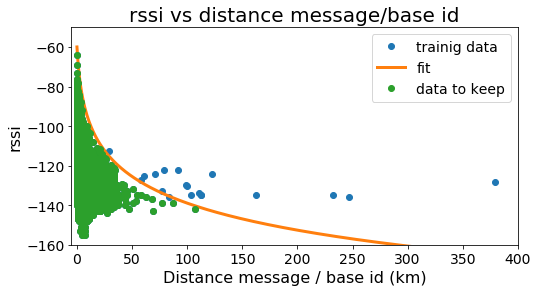

In [605]:
lim = 200
plt.figure(figsize=(8,4))
plt.plot(df['distance'], (df['rssi']), 'o', label='trainig data')
d = np.linspace(0.01, 200, df.shape[0])
plt.plot(-20*np.log(d/0.0005), '-', linewidth=3.0, label='fit')
d_keep = np.exp(-df['rssi']/20)*0.09
plt.plot(df[df['distance'] <= d_keep]['distance'], df[df['distance'] <= tmp]['rssi'], 'o', label='data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi')
plt. title('rssi vs distance message/base id')
plt.xlim(-5,400)
plt.ylim(-160, -50)
plt.legend()

In [586]:
# Calculate the point density
x = df['distance']
y = df['rssi']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)



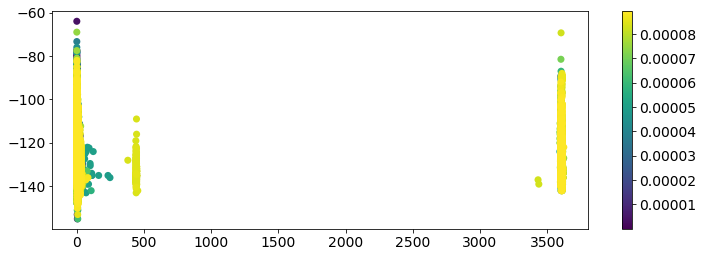

In [604]:
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots(1,1,figsize=(12,4))
cax = ax.scatter(x, y, c=z, s=50, edgecolor='')
cbar = fig.colorbar(cax, orientation='vertical')
#plt.xlim(-10, lim)

## 1.3. Identifying misplaced base stations on training set and correcting them

In [475]:
print(f"There are {round(100 - df[df['distance'] <= d_keep]['distance'].count() * 100 / df['distance'].count(),2)} % of misplaced base stations")


There are 11.68 % of misplaced base stations


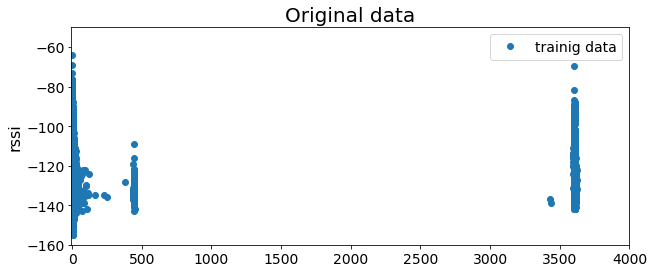

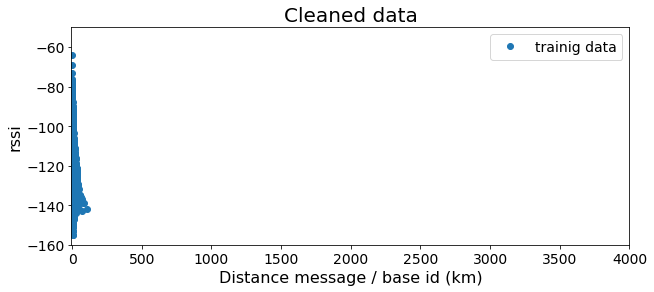

In [476]:
df['mul']=0
df['mul']=df['mul'].where(df['distance'] > d_keep,1)

df_clean = df.copy()
df_clean = df_clean.loc[df_clean['mul'] != 0]

df_u = df.copy()
df_u = df_u.loc[df_u['mul'] == 0]

lim = 4000
plt.figure(figsize=(10,4))
plt.plot(df['distance'], (df['rssi']), 'o', label='trainig data')
plt.ylabel('rssi')
plt. title('Original data')
plt.xlim(-5,lim)
plt.ylim(-160, -50)
plt.legend()

plt.figure(figsize=(10,4))
plt.plot(df_clean['distance'], (df_clean['rssi']), 'o', label='trainig data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi')
plt. title('Cleaned data')
plt.xlim(-5,lim)
plt.ylim(-160, -50)
plt.legend()

In [487]:
X_train = df_clean.copy()
X_test = df_u.copy()
col = ['rssi', 'time_ux','nseq']
X_train = X_train[col]
y_train = df_clean['bs_lat']
X_test = X_test[col]
y_test = df_u['bs_lat']


clr = RandomForestRegressor(n_estimators=100)
clr.fit(X_train, y_train)
y_pred = clr.predict(X_test)

df_u['bs_lat'] = df_u['bs_lat'] * df_u['mul'] + y_pred
#y_pred_lat = reg.predict(df_test) 

In [488]:
X_train = X_train[col]
y_train = df_clean['bs_lng']
X_test = X_test[col]
y_test = df_u['bs_lng']


clr = RandomForestRegressor(n_estimators=100)
clr.fit(X_train, y_train)
y_pred = clr.predict(X_test)

df_u['bs_lng'] = df_u['bs_lng'] * df_u['mul'] + y_pred

In [489]:
frames = [df_clean, df_u]
result = pd.concat(frames)

In [480]:
result.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,distance,mul
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490,1.272501,1
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490,7.864086,1
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554,5.126456,1
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940,11.675512,1
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940,1.355825,1


In [490]:
col = ['messid', 'bsid', 'bs_lat', 'bs_lng','lat', 'lng', 'rssi']
mess_lat = result['lat'] * np.pi / 180
bs_lat = result['bs_lat'] * np.pi / 180
mess_lng = result['lng'] * np.pi / 180
bs_lng = result['bs_lng'] * np.pi / 180

dlon = bs_lng - mess_lng
dlat = bs_lat - mess_lat
R = 6373
a = (np.sin(dlat/2))**2 + np.cos(mess_lat) * np.cos(bs_lat) * (np.sin(dlon/2))**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
distance = R * c
result['distance'] = distance

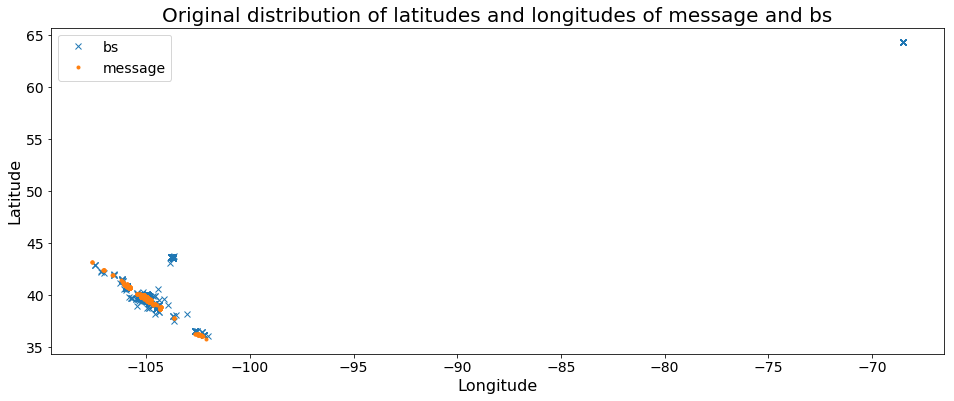

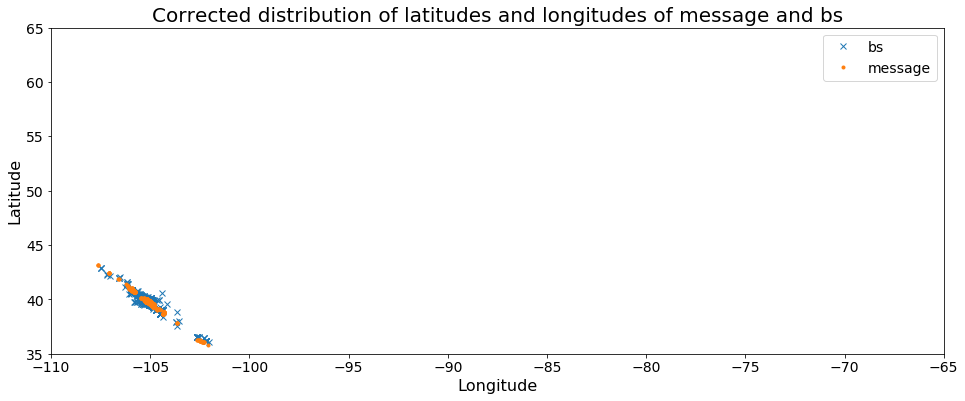

In [503]:
plt.figure(figsize=(16,6))
plt.plot(df['bs_lng'], df['bs_lat'], 'x', label='bs')
plt.xlabel('bs longitude' )
plt.ylabel('bs latitude')

plt.plot(df['lng'], df['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.title('Original distribution of latitudes and longitudes of message and bs')
plt.legend()


plt.figure(figsize=(16,6))
plt.plot(result['bs_lng'], result['bs_lat'], 'x', label='bs')
plt.xlabel('bs longitude' )
plt.ylabel('bs latitude')
plt.xlim(-110, -65)
plt.ylim(35, 65)

plt.plot(result['lng'], result['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.title('Corrected distribution of latitudes and longitudes of message and bs')
plt.xlim(-110, -65)
plt.ylim(35, 65)
plt.legend()

## 1.4. Examinating test set

In [520]:
lst_test = set(df_mess_test['bsid'].unique())
lst_train = set(df_mess_train['bsid'].unique())
print(f"There is {len(lst_test) - len(lst_test.intersection(lst_train))} different stations between train and test")

lst_test = set(df_mess_test['did'].unique())
lst_train = set(df_mess_train['did'].unique())
print(f"There is {len(lst_test) - len(lst_test.intersection(lst_train))} different devices between train and test")

There is 8 different stations between train and test
There is 56 different devices between train and test


## Spatial location

## Number of messages

NTotal number of messages: 6068
Messages received by more than 3 stations : 47.97 %
Messages received by 3 stations: 14.42 %
Messages received by 2 stations: 15.71 %
Messages received by one station: 21.90 %


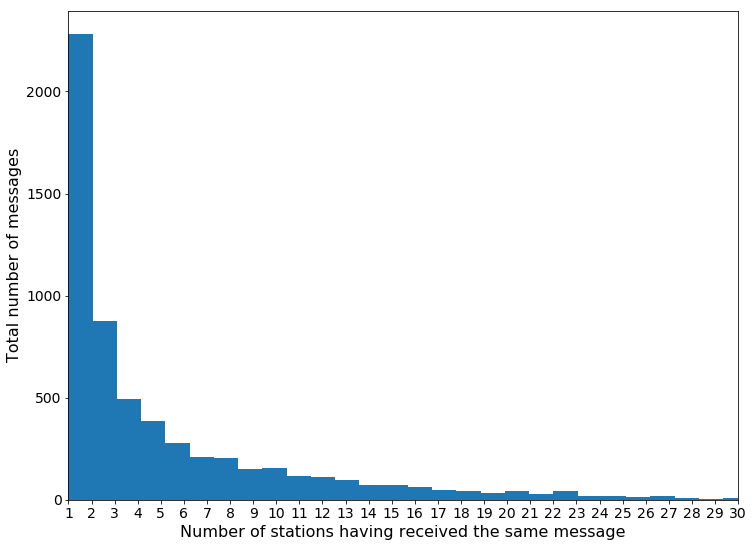

In [116]:
data = df_mess_train.groupby(['messid']).count()["bsid"]
data_with_3_pos_more = data[data>3].count()
data_with_3_pos = data[data==3].count()
data_with_2_pos = data[data==2].count()
data_with_1_pos = data[data==1].count()

print(f"NTotal number of messages: {data.shape[0]}")
print("Messages received by more than 3 stations : %2.2f" %(data_with_3_pos_more / data.shape[0] * 100), "%")
print("Messages received by 3 stations: %2.2f" %(data_with_3_pos / data.shape[0] * 100), "%")
print("Messages received by 2 stations: %2.2f" %(data_with_2_pos / data.shape[0] * 100), "%")
print("Messages received by one station: %2.2f" %(data_with_1_pos /data.shape[0] * 100), "%")

plt.figure(figsize=(12,9))
plt.hist(data, bins= 100)
plt.xlabel("Number of stations having received the same message")
plt.ylabel("Total number of messages")
plt.xlim([1, 30])
plt.xticks(np.arange(1, 30+1, 1.0))
plt.show()

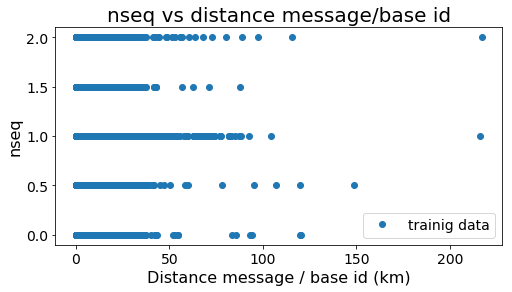

In [580]:
plt.figure(figsize=(8,4))
#plt.plot(df['distance'], (df['rssi']), 'o', label='trainig data')
plt.plot(result['distance'], (result['nseq']), 'o', label='trainig data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('nseq')
plt. title('nseq vs distance message/base id')
plt.legend()

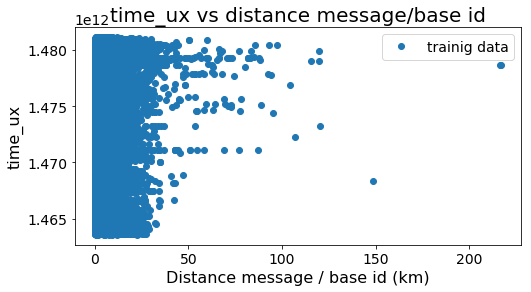

In [582]:
plt.figure(figsize=(8,4))
#plt.plot(df['distance'], (df['rssi']), 'o', label='trainig data')
plt.plot(result['distance'], (result['time_ux']), 'o', label='trainig data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('time_ux')
plt. title('time_ux vs distance message/base id')
plt.legend()

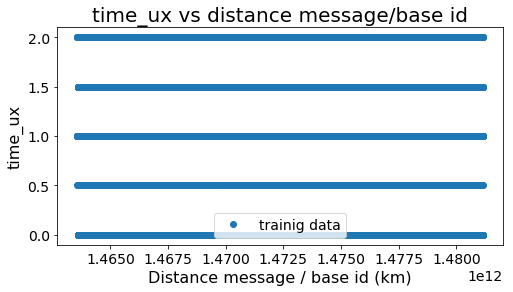

In [585]:
plt.figure(figsize=(8,4))
#plt.plot(df['distance'], (df['rssi']), 'o', label='trainig data')
plt.plot(result['time_ux'], (result['nseq']), 'o', label='trainig data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('nseq')
plt. title('time_ux')
plt.legend()

## Other

In [521]:
# Feature Matrix construction 

def feat_mat_const(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = 1
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

In [522]:
df_mess_a = df_mess_train.groupby(['messid'], as_index=False).count()
df_mess_a.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000
mean,6.468359,6.468359,6.468359,6.468359,6.468359,6.468359,6.468359
std,8.997655,8.997655,8.997655,8.997655,8.997655,8.997655,8.997655
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
max,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000


In [527]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [556]:
#df_feat, id_list_train = feat_mat_const(df_mess_train, listOfBs)
df_feat, id_list_train = feat_mat_const(result, listOfBs)

In [554]:
result.groupby(['messid'], as_index=False).max()
len(np.unique(result['messid']))

6068

In [560]:
#ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat, ground_truth_lng = ground_truth_const(result, pos_train)

ground_truth_lat.shape

(6068,)

In [11]:
# Validation

In [529]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    from sklearn import linear_model

    X_train = np.array(df_feat);
    #reg = linear_model.LinearRegression()
    reg = RandomForestRegressor()

    reg.fit(X_train, ground_truth_lat);
    y_pred_lat = reg.predict(df_test) 

    reg.fit(X_train, ground_truth_lng);
    y_pred_lng = reg.predict(df_test) 
    
    
    
    return y_pred_lat, y_pred_lng


In [13]:
# Make regressor and prediction using the train set

In [561]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

/home/alba/miniconda3/envs/MY_ENV_P37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [15]:
# Cross validation

In [531]:
from sklearn.model_selection import cross_val_predict

In [562]:
from sklearn import linear_model
#reg = linear_model.LinearRegression()
reg = RandomForestRegressor()

y_pred_lng = cross_val_predict(reg, df_feat, ground_truth_lng, cv=10)
y_pred_lat = cross_val_predict(reg, df_feat, ground_truth_lat, cv=10)

/home/alba/miniconda3/envs/MY_ENV_P37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alba/miniconda3/envs/MY_ENV_P37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alba/miniconda3/envs/MY_ENV_P37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alba/miniconda3/envs/MY_ENV_P37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

In [18]:
# Evaluate result

In [566]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [567]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [535]:
y_pred_lat[y_pred_lat < -90] = -90

In [536]:
y_pred_lat[y_pred_lat > 90] = 90

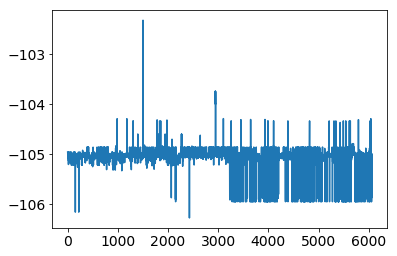

In [571]:
plt.figure()
plt.plot(y_pred_lng)

In [572]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

/home/alba/miniconda3/envs/MY_ENV_P37/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


In [25]:
# Plot error distribution

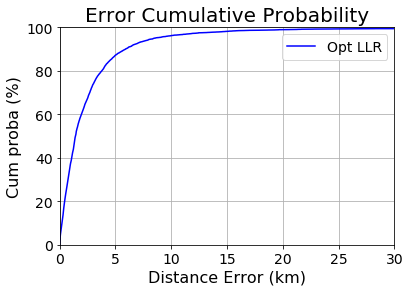

In [573]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [574]:
# Error criterion

np.percentile(err_vec, 80)

3796.2940687701603

In [28]:
# Construct test prediction

In [29]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [30]:
df_feat_test, id_list_test = feat_mat_const(df_mess_test, listOfBs)

In [31]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

/home/alba/miniconda3/envs/MY_ENV_P37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [32]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test

In [33]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [34]:
test_res.head()

,lat,lng,messid
0,39.724281,-105.056706,573be2503e952e191262c351
1,39.782389,-105.068339,573c05f83e952e1912758013
2,39.681743,-105.020011,573c0796f0fe6e735a66deb3
3,39.791444,-105.085723,573c08d2864fce1a9a0563bc
4,39.681743,-105.020011,573c08ff864fce1a9a0579b0
